### Using Python and R Together

Python has many tools not available in R and some tools that work more efficiently or intuitively than in R. For instance, in the `nao` Jupyter Notebook I use Python to generate the base map for Figure 4 of Fastovich et al., 2020, GRL because Python modules like `xarray` make working with mutlidimensional netCDF files a breeze. One line of code using `xarray` would be 30+ lines of R code. But Python isn't all great - many of the modules lack the polish and ease of use of many R packages. In the `nao` notebook I run a regression using a single line of code just as in R. However, this does not automatically perform any diagnostics, produce diagnostic plots, or even summarize the results. Leveraging the strenghts and weakness of each language is possible using Jupyter notebooks!

Here, we'll be using Python to read in a netCDF file and plot it using `ggplot2` in R. Why use `ggplot2` instead of plotting in R? Because no Python modules make plotting as simple as `ggplot2`.

*Note: generally data scientists prefer Python becuase it has a FANTASTIC machine learning module in [scikit-learn](https://scikit-learn.org/stable/index.html) while R has many more well polished and niche packages, like `neotoma`.*

In [5]:
# We'll be calling R from within Python, so load necessary Python modules

%load_ext rpy2.ipython # Module that allows R and Python to interface in the same notebook
import xarray as xr
import pandas as pd

### Opening meteorological data using `xarray`

I've said that Python's xarray module is amazing, and it is. So let's load in some sample date - the wind speed of the jet streams from 1948 to 2016. This file is called *U500.nc* and is in a netCDF4 format. netCDF files are great for climate model and meteorological data because it easy stores multidimensional data like time, latitude, longitude, and height in the atmoshpere. 

![netcdf illustration](img/netcdf.png)

We'll read in this netCDF data using the `open_dataset` function in the xarray module called using Python dot notation. We've asked Python to call `xarray` using the `xr` name to reduce the amount of typing that we have to do.

In [6]:
# Read in U500.nc from the root of the directory
u500 = xr.open_dataset('U500.nc')

# Let's see the structure of the data
u500

<xarray.Dataset>
Dimensions:  (lat: 73, level: 1, lon: 144, time: 877)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 500.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-01-01
Data variables:
    uwnd     (time, level, lat, lon) float32 ...
Attributes:
    title:          monthly mean u wind from the NCEP Reanalysis
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....
    history:        Fri Mar 12 08:28:13 2021: ncks -O -d lat,-90.000000,90.00...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

We can see a lot of useful information about this data! The dimensions are latitude, longitude, level in the atmosphere (the jet stream occurs anywhere from 500 mb to 200 mb in the atmosphere pressure surface). The actual data is stored in the `uwnd` data variable and we can call it using Python dot notation. Think of this very loosly as the ` $ ` operator in R.

In [7]:
# Print data
print(u500.uwnd)

<xarray.DataArray 'uwnd' (time: 877, level: 1, lat: 73, lon: 144)>
[9219024 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 500.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-01-01
Attributes:
    long_name:     Monthly mean u wind
    units:         m/s
    precision:     2
    var_desc:      u-wind
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Other
    valid_range:   [-125.  160.]
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-68.194824 124.399994]


A very useful feature of `xarray` are *methods* that enable the same action to be performed on any data read in. Let's demonstrate how this works by taking the average of the data through time and then quickly producing a plot - all in a single line of code!

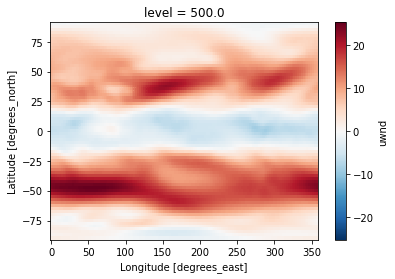

In [8]:
# Again using dot notation here
# .mean tells xarray to take an average and we specify the 'time' dimension
# .plot tells xarray to produce a plot of the spatial data

u500.uwnd.mean('time').plot()

Let's use this same dot notation and averaging methods to take the zonal average. The zonal average (average wind speed across a single line of latitude) gives a good idea of the average direction of the jet stream across different lines of latitude. Let's see the average direction of the jet stream in this entire dataset.

In [9]:
# .mean() through time
# .mean() across lines of longitude produces a latitudinal average

u500_zonal = u500.uwnd.mean('time').mean('lon')

Let's also examine how the strength of the norhtern hemispheric midlatitudinal jet stream has changed through time. Here, we will you use the `sel` method to select all data closest to Madison, WI (43.073051 N, 89.401230 W).

In [10]:
u500_madison = u500.uwnd.sel(lat=43.073051, method='nearest').sel(lon=(-89.401230 + 360), method='nearest') # Longitude is in degrees east from the prime meridian which is why I'm adding 360 degrees to -89, the longitude of Madison

Now let's get ready to pass this time series data to R using the Python `pandas` module. Why `pandas`? Because the `pandas` data frame is effectively the same structure as an R data.frame, so the hand off will be seamless!

In [11]:
# Pandas data from for the zonally average jet stream velocity

pd_u500 = pd.DataFrame({'lat':u500_zonal.lat.values,
                       'u500':u500_zonal.values.flatten()})

# Pandas data from for the jet stream velocity through time over Madison
pd_u500_madison = pd.DataFrame({'time':u500_madison.time.values,
                                'u500':u500_madison.values.flatten()})

### Passing data to R

Here is where the magic happens! The `%%R` line at the top of the cell tells Jupyter Lab to run this cell in R and the -i command tells it to pass pd_500 from Python to R. It'll appear in R as a normal dataframe and we can make a line plot using `ggplot2`.

'data.frame':	73 obs. of  2 variables:
 $ lat : num  90 87.5 85 82.5 80 77.5 75 72.5 70 67.5 ...
 $ u500: num  0.009 0.574 1.392 2.352 3.143 ...


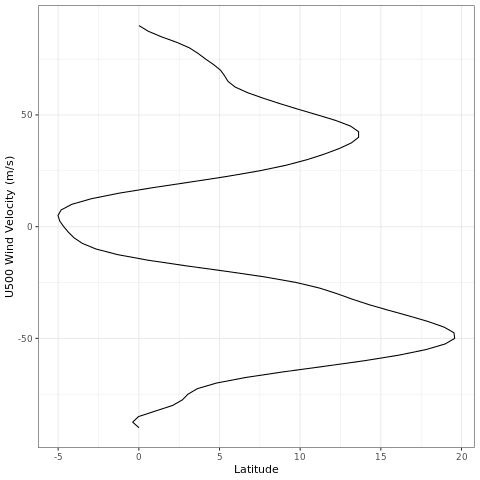

In [12]:
%%R -i pd_u500

# Load the ggplot2 library
library("ggplot2")

# Let's verify that the data passed through nice and is actually a data frame
str(pd_u500)

# Plot zonal average of the jet stream
zonal_u500_plot <- ggplot(data=pd_u500, aes(x = lat, y = u500)) + geom_line() + coord_flip() + xlab('U500 Wind Velocity (m/s)') + ylab('Latitude')

# Make the plot pretty
zonal_u500_plot + theme_bw()

Your turn to practice: use the cell below to pass `pd_u500_madison` to R and create a plot of the time series using `ggplot2`.